In [3]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

import nest_asyncio
nest_asyncio.apply()

# State Definition

In [4]:
from typing import TypedDict, List, Annotated
from playwright.async_api import Page
from langchain_core.messages import BaseMessage
from operator import add

class Bbox(TypedDict):
    x: int
    y: int
    text: str
    type: str
    ariaLabel: str

class Action(TypedDict):
    action: str
    args: str | Bbox

class AgentState(TypedDict):
    input: str
    page: Page
    image: str
    bboxes: List[Bbox]
    actions_taken: Annotated[List[str], add]
    action: Action | str
    last_action: str
    notes: Annotated[List[str], add]
    answer: str


# ScreenShot and Annotation Helper Functions

In [5]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io
from playwright.async_api import Page


with open("mark_page.js") as f:
    mark_page_script = f.read()

async def is_image_blank(image_bytes: bytes) -> bool:
    """Return True if the screenshot is fully blank (e.g. all white), else False."""
    if not image_bytes:
        return True
    img = PILImage.open(io.BytesIO(image_bytes)).convert("L")
    # If getbbox() returns None, the image is entirely one color
    return img.getbbox() is None

async def capture_screenshot(page: Page, max_retries=3, wait_seconds=2) -> bytes:
    """Take a screenshot, retry if blank (completely white)."""
    screenshot_bytes = b""
    for attempt in range(max_retries):
        # Wait for the page to be fully loaded
        await page.wait_for_load_state("networkidle")
        
        # Take screenshot
        screenshot_bytes = await page.screenshot(path="screenshot.jpg", type="jpeg", quality=60, scale="device", full_page=True)
        
        # Check if it's blank
        if not await is_image_blank(screenshot_bytes):
            return screenshot_bytes
        
        # If blank, wait a bit and retry
        print(f"[capture_screenshot] Screenshot is blank (attempt {attempt+1}/{max_retries}). Retrying...")
        await asyncio.sleep(wait_seconds)
    
    # If we get here, all attempts yielded a blank screenshot
    print("[capture_screenshot] All screenshot attempts were blank.")
    return screenshot_bytes  # Return whatever we got last


async def mark_page(page):

    """
    1. Wait for the page to be loaded using 'networkidle'.
    2. Attempt to run a 'mark_page_script' that presumably marks and returns bounding boxes.
    3. Retry up to 10 times if it fails.
    4. Capture a screenshot with retry logic (up to 3 tries) if the page is blank.
    5. Process screenshot (grayscale, resize, quantize, compress).
    6. Remove the markings before returning.
    """

    bboxes = []

    for attempt in range (3):
        
        try: 
            await page.wait_for_load_state("networkidle")
            await page.wait_for_load_state("domcontentloaded")
            await page.evaluate(mark_page_script)
            bboxes = await page.evaluate("markPage()")
            
            break
        except Exception as e:
            print(f"[mark_page] Attempt {attempt+1}/3 failed to mark page: {e}")
            await asyncio.sleep(3)
    # Get screenshot as bytes
    await page.wait_for_load_state("networkidle")
    screenshot_bytes = await capture_screenshot(page, max_retries=3)
    
    # Process screenshot if we have any bytes
    if screenshot_bytes:
        img = PILImage.open(io.BytesIO(screenshot_bytes))
        # Convert to grayscale
        img = img.convert('L')
        # Resize
        max_size = (600, 600)
        img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
        # Quantize and convert back to grayscale
        img = img.quantize(colors=256).convert('RGB')
        
        # Compress
        buffer = io.BytesIO()
        img.save(
            buffer,
            format='JPEG',
            quality=50,      # Low quality -> smaller size
            optimize=True,
            progressive=True
        )
        compressed_bytes = buffer.getvalue()
    else:
        # If screenshot is empty or never taken, handle gracefully
        print("[mark_page] Using empty screenshot due to failure or blank screenshot.")
        compressed_bytes = b""

    await page.wait_for_load_state("networkidle")
    try:
        await page.evaluate("unmarkPage()")
    except Exception as e:
        print(f"[mark_page] Could not unmark page: {e}")

    # Build final result
    return {
        "image": base64.b64encode(compressed_bytes).decode("utf-8"),
        "bboxes": bboxes
    }

In [6]:
async def mark_page_2(page):
    """
    Force mark page and capture visible content even if page isn't fully loaded.
    """
    bboxes = []
    
    # Quick initial wait for basic content
    try:
        # Wait for DOM content - this is usually faster than waiting for network idle
        await page.wait_for_load_state("domcontentloaded", timeout=10000)
    except Exception as e:
        print(f"[mark_page] Warning: Basic load timeout, proceeding anyway: {e}")
    
    # Force mark attempt regardless of load state
    for attempt in range(3):
        try:
            # Try to mark visible elements
            await page.evaluate(mark_page_script)
            bboxes = await page.evaluate("markPage()")
            
            # If we got any bboxes, consider it a success
            if bboxes and len(bboxes) > 0:
                print(f"[mark_page] Successfully found {len(bboxes)} elements")
                break
                
            print(f"[mark_page] Attempt {attempt+1}: No elements found, retrying...")
            await asyncio.sleep(1)  # Short wait between attempts
            
        except Exception as e:
            print(f"[mark_page] Attempt {attempt+1}/3 failed: {e}")
            await asyncio.sleep(1)
    
    # Take screenshot of whatever is visible
    try:
        # Force a viewport screenshot rather than full page
        screenshot_bytes = await page.screenshot(
            timeout=5000,  # Short timeout
            full_page=False,
               
        )
    except Exception as e:
        print(f"[mark_page] Screenshot failed: {e}")
        screenshot_bytes = b""
    
    # Process screenshot if we have any bytes
    if screenshot_bytes:
        img = PILImage.open(io.BytesIO(screenshot_bytes))
        img = img.convert('L')
        max_size = (300, 300)
        img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
        img = img.quantize(colors=16).convert('L')
        
        buffer = io.BytesIO()
        img.save(
            buffer,
            format='JPEG',
            quality=5,
            optimize=True,
            progressive=True
        )
        compressed_bytes = buffer.getvalue()
    else:
        print("[mark_page] Using empty screenshot")
        compressed_bytes = b""

    # Try to clean up, but don't wait long
    try:
        await page.evaluate("unmarkPage()", timeout=5000)
    except Exception as e:
        print(f"[mark_page] Cleanup warning (non-critical): {e}")

    return {
        "image": base64.b64encode(compressed_bytes).decode("utf-8"),
        "bboxes": bboxes
    }

# Browser setup

In [7]:
async def setup_browser(go_to_page: str):
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False, args=['--disable-dev-shm-usage'])
    page = await browser.new_page()
    try:
        # Increase timeout to 80 seconds and add wait_until option
        await page.goto(go_to_page, timeout=80000, wait_until="domcontentloaded")
    except Exception as e:
        print(f"Error loading page: {e}")
        # Fallback to Google if the original page fails to load
        await page.goto("https://www.google.com", timeout=60000, wait_until="domcontentloaded")
    return playwright, browser, page

In [8]:
async def setup_browser_2(go_to_page: str):
    playwright = await async_playwright().start()
    
    # Add browser arguments to appear more human-like
    browser_args = [
        '--disable-dev-shm-usage',
        '--disable-blink-features=AutomationControlled',  # Hide automation
        '--no-sandbox',
        '--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',  # Use a common user agent
    ]
    
    # Add browser context options
    context_options = {
        "viewport": {"width": 1920, "height": 1080},  # Standard desktop resolution
        "user_agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
        "permissions": ['geolocation'],
        "geolocation": {"latitude": 37.7749, "longitude": -122.4194},  # Set a fixed location
        "locale": 'en-US',
        "timezone_id": 'America/Los_Angeles',
    }
    
    browser = await playwright.chromium.launch(
        headless=False,
        args=browser_args
    )
    
    # Create context with the specified options
    context = await browser.new_context(**context_options)
    
    # Enable JavaScript and cookies
    await context.add_init_script("""
        Object.defineProperty(navigator, 'webdriver', {
            get: () => undefined
        });
    """)
    
    page = await context.new_page()
    
    try:
        await page.goto(go_to_page, timeout=80000, wait_until="domcontentloaded")
    except Exception as e:
        print(f"Error loading page: {e}")
        # Fallback to Google if the original page fails to load
        await page.goto("https://www.google.com", timeout=60000, wait_until="domcontentloaded")
    
    return playwright, browser, page

# Page annotation node

In [9]:
from pprint import pprint
async def annotate_page(state: AgentState):
    page = state["page"]
    result = await mark_page(page)
    return {"image": result["image"], "bboxes": result["bboxes"]}




# Prompt Definition and LLM Call Node

In [11]:
from langchain_core.prompts import ChatPromptTemplate

async def llm_call_node(state: AgentState) -> AgentState:   

    template =  """Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration,
    you will receive an Observation that includes a screenshot of a webpage and some texts. 
    Carefully analyze the bounding box information and the web page contents to identify the Numerical Label corresponding 
    to the Web Element that requires interaction, then follow
    the guidelines and choose one of the following actions:

    1. Click a Web Element.
    2. Delete existing content in a textbox and then type content.
    3. Scroll up or down.
    4. Wait 
    5. Go back
    7. Return to google to start over.
    8. Respond with the final answer

    Correspondingly, Action should STRICTLY follow the format:

    - Click [Numerical_Label] 
    - Type [Numerical_Label]; [Content] 
    - Scroll [Numerical_Label or WINDOW]; [up or down] 
    - Wait 
    - GoBack
    - Google
    - Respond

    Key Guidelines You MUST follow:

    * Action guidelines *
    1) Execute only one action per iteration.
    2) Always click close on the popups.
    3) When clicking or typing, ensure to select the correct bounding box.
    4) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.

    * Web Browsing Guidelines *
    1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
    2) Select strategically to minimize time wasted.

    Your reply should strictly follow the format:

    Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}
    Action: {{One Action format you choose}} (Make sure to enclose the bbox id in [] , for eg  Click [1], Type [5], Scroll [10] or Scroll [WINDOW])
    Then the User will provide:
    Observation: {{A labeled bounding boxes and contents given by User}}"
    Actions Taken: {{A list of actions taken so far}} (Could be empty, if it is the first iteration)

    Based on the actions taken so far and the observation, determine the next action to take (click, type, scroll, wait, go back, go to search engine).

    Observation including a screenshot of a webpage with bounding boxes and the text related to it: {{result}}"""


    prompt = ChatPromptTemplate(
        messages=[
            ("system", template),
            ("human", "Input: {input}"),
            ("human", "Actions Taken So far: {actions_taken}"),
            ("human", "Observation: Screenshot: {image}"),
            ("human", "Observation: Bounding Boxes: {bboxes}"),
            
        ],
        input_variables=["image", "bboxes", "input"],
        partial_variables={"actions_taken": []},
        optional_variables=["actions_taken"]
    )
    
    

    actions_taken = state.get("actions_taken", [])
    image = state["image"]
    bboxes = state["bboxes"]
    input = state["input"]

    prompt_value = prompt.invoke({"actions_taken": actions_taken, "image": image, "bboxes": bboxes, "input": input})
    
    llm = ChatOpenAI(model="gpt-4o", max_tokens =4096, temperature=0)
    response = llm.invoke(prompt_value)

    action = response.content
    
    pprint(state)
    return {"action": action}





## Parse Action

In [12]:
async def parse_action_node(state: AgentState):
    action_prefix = "Action: "
    text = state["action"]
    if not text.strip().split("Action:")[-1]:
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("Action: ")[-1]
    split_output = action_block.split("; ", 1)
    if len(split_output) == 1:
        action, args = split_output[0], None
    else:
        action, args = split_output

    return {"action": Action(action=action, args=args)}


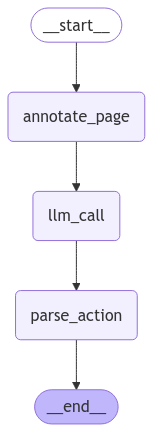

In [13]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

sub_agent_builder = StateGraph(AgentState)

sub_agent_builder.add_node("annotate_page", annotate_page)
sub_agent_builder.add_node("llm_call", llm_call_node)
sub_agent_builder.add_node("parse_action", parse_action_node)

sub_agent_builder.add_edge(START, "annotate_page")
sub_agent_builder.add_edge("annotate_page", "llm_call")
sub_agent_builder.add_edge("llm_call", "parse_action")
sub_agent_builder.add_edge("parse_action", END)

sub_agent_graph = sub_agent_builder.compile()

display(Image(sub_agent_graph.get_graph().draw_mermaid_png()))


# Tools
1. Click (at labelled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)



### Click

In [14]:
async def click(state: AgentState):
    page = state["page"]
    action = state["action"]
    bbox_id = int(action["action"].split(" ")[1].split("[")[1].split("]")[0])
    if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
        return {"action": "retry", "args": f"Could not find bbox with id {bbox_id}"}
    bbox = state["bboxes"][bbox_id]
    await page.mouse.click(bbox["x"], bbox["y"])
    return {"last_action": f"Click : clicked on {bbox_id}", "actions_taken": [f"Click : clicked on {bbox_id}"]}

#result = await click(response)
#result
    

### Type


In [15]:
import platform

async def type(state: AgentState):
    page = state["page"]
    action = state["action"]
    bbox_id = int(action["action"].split("[")[1].split("]")[0])
    if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
        return {"action": "retry", "args": f"Could not find bbox with id {bbox_id}"}
    bbox = state["bboxes"][bbox_id]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(action["args"])
    await page.keyboard.press("Enter")
    return {"last_action": f"Type : typed {action['args']} into {bbox_id}", "actions_taken": [f"Type : typed {action['args']} into {bbox_id}"]}

#result = await type(response)
#result

In [16]:
async def scroll(state: AgentState):
    page = state["page"]
    action = state["action"]
    scroll_type = action["action"].split(" ")[1].split("[")[1].split("]")[0]
    direction = action["args"]
    if scroll_type == "WINDOW":
        scroll_amount = 500
        scroll_direction = (-scroll_amount if direction.lower() == "up" else scroll_amount)
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
        return {"last_action": f"Scroll : scrolled {direction} by {scroll_direction}", "actions_taken": [f"Scroll : scrolled {direction} by {scroll_direction}"]}
    else:
        bbox_id = int(action["action"].split("[")[1].split("]")[0])
        if bbox_id not in [bbox["id"] for bbox in state["bboxes"]]:
            return {"action": "retry", "args": f"Could not find bbox with id {bbox_id}", "actions_taken": [f"Could not find bbox with id {bbox_id}"]}
        bbox = state["bboxes"][bbox_id]
        scroll_amount = 200
        scroll_direction = -scroll_amount if scroll_direction.lower() == "up" else scroll_amount
        await page.mouse.move(bbox["x"], bbox["y"])
        await page.mouse.wheel(0, scroll_direction)
        return {"last_action": f"Scroll : scrolled down to {bbox_id}", "actions_taken": [f"Scroll : scrolled down to {bbox_id}"]}

#result = await scroll(response)
#result


In [17]:
async def wait(state: AgentState):
    await asyncio.sleep(3)
    return {"last_action": "Wait : waited for 3 seconds", "actions_taken": ["Wait : waited for 3 seconds"]}

#   result = await wait(response)
#result

In [18]:
async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return {"last_action": f"Go Back : Navigated back to page {page.url}", "actions_taken": [f"Go Back : Navigated back to page {page.url}"]}

#result = await go_back(response)
#result

In [19]:
async def go_to_search_engine(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com")
    return {"last_action": "Go to Search Engine : Navigated to Google", "actions_taken": ["Go to Search Engine : Navigated to Google"]}

#result = await go_to_search_engine(response)
#result

In [20]:
async def annotate_page_after_action(state: AgentState):
    await asyncio.sleep(3)

    page = state["page"]
    result = await mark_page(page)
    return {"image": result["image"], "bboxes": result["bboxes"]}

In [48]:

async def updates_notes_self_review_node(state: AgentState):
    
    
    await annotate_page(state)

    
    system_message_notes = """You are an expert assistant at analyzing web page screenshots and extracting information relevant to the user's input.

    You will be given:
    Screenshot: {image}
    User Input: {input}

    Just give a one sentence summary of the information you see in the screenshot that is relevant to the user's input.

    """

    prompt_notes = ChatPromptTemplate(
        messages=[
            ("system", system_message_notes),
            ("human", "Screenshot: {image}"),
            ("human", "User Input: {input}")
        ],
        input_variables=["image", "input"],
    )
    image = state["image"]
    input = state["input"]

    prompt_value_notes = prompt_notes.invoke({"image": image, "input": input})

    llm = ChatOpenAI(model="gpt-4o", max_tokens =4096, temperature=0)
    response_notes = llm.invoke(prompt_value_notes)
    note = response_notes.content
    

    return {"notes": [note]}

from pydantic import BaseModel, Field

class SelfReview(BaseModel):
    self_review: str = Field(..., description="Answer in one of the words YES or NO")

async def self_review_node(state: AgentState):
    notes = state["notes"]
    system_message_self_review = """You are an expert assistant responsible for determining if the provided notes contain a DIRECT AND COMPLETE ANSWER to the user's input query.

    You will be given:
    Notes: {notes}
    User Input: {input}

    Analyze the notes carefully using these criteria:
    1. Do the notes contain the ACTUAL ANSWER to the user's question? 
       - Instructions on how to find the answer are NOT sufficient
       - Explanations of what tools to use are NOT sufficient
       - The notes must contain the specific information requested
    
    2. Is the answer COMPLETE?
       - All aspects of the user's question must be addressed
       - Partial answers are NOT sufficient
    
    3. Is the answer DIRECT?
       - The information must be from actual data/content seen in the screenshot
       - Theoretical or hypothetical answers are NOT sufficient

    Based on your analysis, respond with EXACTLY one word:
    YES: ONLY if the notes contain the actual, complete, direct answer to the user's question
    NO: If the notes only contain instructions, partial answers, or no answer at all

    Example:
    User Input: "What time is the next train?"
    Notes that deserve YES: "The next train departs at 3:45 PM"
    Notes that deserve NO: "You need to check the train schedule to find departure times"
    """

    prompt_self_review = ChatPromptTemplate(
        messages=[
            ("system", system_message_self_review),
        ],
        input_variables=["notes", "input"],
    )

    notes = state["notes"]
    input = state["input"]

    prompt_value_self_review = prompt_self_review.invoke({"notes": notes, "input": input})
    llm = ChatOpenAI(model="gpt-4o", max_tokens =4096, temperature=0)
    response_self_review = llm.with_structured_output(SelfReview).invoke(prompt_value_self_review)
    self_review = response_self_review

    print(self_review)
    
    if self_review.self_review == "YES":
        return "answer_node"
    else:
        return "annotate_page"


In [51]:
image = """"""

input = "What is the time I should leave to get to San Francisco International Airport (SFO) by 7 o'clock from downtown San Francisco?"

state = AgentState(input= input, image=image)

result = await updates_notes_self_review_node(state)
result




KeyError: 'page'

In [28]:
notes = ["""The screenshot provided does not contain any information from Google Maps or any other navigation tool that could help determine the time you should leave to get to San Francisco International Airport (SFO) by 7 o'clock from downtown San Francisco. 

To find this information, you would need to:

1. Open Google Maps on your device.
2. Enter your starting point as "SF downtown" and your destination as "SFO".
3. Set the arrival time to 7:00 AM.
4. Google Maps will then calculate the estimated departure time based on current traffic conditions and provide you with the best route options.

If you are using a mobile device, you can also use the "Depart at" or "Arrive by" feature to set your desired arrival time and get the recommended departure time."""]


input = "What is the time I should leave to get to San Francisco International Airport (SFO) by 7 o'clock from downtown San Francisco?"
state = AgentState(notes=notes, input=input)

result = await self_review_node(state)
result


self_review='YES'


'answer_node'

In [30]:
async def answer_node(state: AgentState):
    system_message_answer = """ You are an assistant who is expert at answering the user input based on the notes.
    You will be given:
    Notes: {notes}
    User Input: {input}

    Analyze the notes and answer the user input.
    Answer should be in proper Markdown format.
    """

    prompt_answer = ChatPromptTemplate(
        messages=[
            ("system", system_message_answer),
        ],
        input_variables=["notes", "input"],
    )   

    notes = state["notes"]
    input = state["input"]

    prompt_value_answer = prompt_answer.invoke({"notes": notes, "input": input})
    llm = ChatOpenAI(model="gpt-4o-mini", max_tokens =4096, temperature=0)
    response_answer = llm.invoke(prompt_value_answer)
    answer = response_answer.content
    
    return {"answer": answer}


In [31]:
notes = ["""You should leave downtown San Francisco by 6:00 AM to get to San Francisco International Airport (SFO) by 7:00 AM."""]


input = "What is the time I should leave to get to San Francisco International Airport (SFO) by 7 o'clock from downtown San Francisco?"
state = AgentState(notes=notes, input=input)

result = await answer_node(state)
result


{'answer': 'To arrive at San Francisco International Airport (SFO) by 7:00 AM, you should leave downtown San Francisco by **6:00 AM**.'}

In [32]:
tools = {
    "Click": "click",
    "Type": "type",
    "Scroll": "scroll",
    "Wait": "wait",
    "Go Back": "go_back",
    "Google": "go_to_search_engine"
}


In [33]:
from langgraph.graph import  END


def tool_router(state: AgentState):
    action = state["action"]["action"]
    action_type = action.split(" ")[0]
    print(action_type)
    if action_type == "retry":
        return "annotate_page"
    if action_type == "Respond":
        return "updates_notes_self_review_node"
    return tools[action_type]


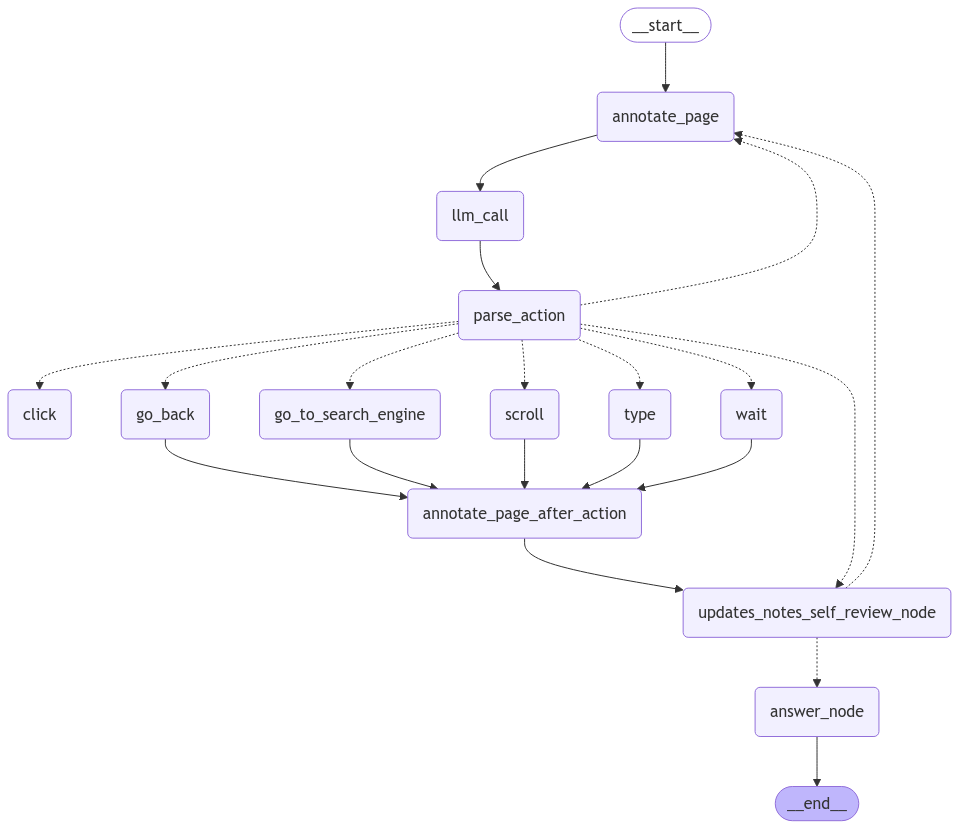

In [49]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(AgentState)

builder.add_node("annotate_page", annotate_page)
builder.add_node("llm_call", llm_call_node)
builder.add_node("parse_action", parse_action_node)
builder.add_node("updates_notes_self_review_node", updates_notes_self_review_node)
#builder.add_node("sub_agent", sub_agent_builder.compile())
builder.add_node("click", click)
builder.add_node("type", type)
builder.add_node("scroll", scroll)
builder.add_node("wait", wait)
builder.add_node("go_back", go_back)
builder.add_node("go_to_search_engine", go_to_search_engine)
builder.add_node("answer_node", answer_node)
builder.add_node("annotate_page_after_action", annotate_page_after_action)

builder.add_edge(START, "annotate_page")
builder.add_edge("annotate_page", "llm_call")
builder.add_edge("llm_call", "parse_action")
builder.add_conditional_edges("parse_action", tool_router, ["annotate_page",  "click", "type", "scroll", "wait", "go_back", "go_to_search_engine", "updates_notes_self_review_node"])
builder.add_edge("click", "annotate_page_after_action")
builder.add_edge("type", "annotate_page_after_action")
builder.add_edge("scroll", "annotate_page_after_action")
builder.add_edge("wait", "annotate_page_after_action")
builder.add_edge("go_back", "annotate_page_after_action")
builder.add_edge("go_to_search_engine", "annotate_page_after_action")
builder.add_edge("annotate_page_after_action", "updates_notes_self_review_node")
builder.add_conditional_edges("updates_notes_self_review_node", self_review_node, ["answer_node", "annotate_page"])
builder.add_edge("answer_node", END)

main_agent_graph = builder.compile()

display(Image(main_agent_graph.get_graph(xray=1).draw_mermaid_png()))

In [47]:
result = await setup_browser_2("https://www.google.com/")
playwright, browser, page = result


In [52]:
input = "What are the latest blogposts on Langchain"
state = AgentState(page=page, input=input)

async for event in main_agent_graph.astream(state, {"recursion_limit": 400}):
    print(event)


{'annotate_page': {'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDABALDA4MChAODQ4SERATGCgaGBYWGDEjJR0oOjM9PDkzODdASFxOQERXRTc4UG1RV19iZ2hnPk1xeXBkeFxlZ2P/2wBDARESEhgVGC8aGi9jQjhCY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2NjY2P/wgARCAFSAlgDASIAAhEBAxEB/8QAGgABAQEBAQEBAAAAAAAAAAAAAAIDAQQFBv/EABQBAQAAAAAAAAAAAAAAAAAAAAD/2gAMAwEAAhADEAAAAfuTp5j0efSDesNzoAAAAAAAAAAAAAAAAAAAAAAAAAAAHO8Pne7LhPpyguqgx+b7/jnq18fD9I4LAAAAAAAAAAAAAcHQAAAAAAAAAAAAAAAAAAAc5QlQlQ46AAAAAAAAAAAAAMJ16UkUkUkUkUnE9DHQpIpIpIpIruegAAAAAAAAAAAAAAAAAAAAAAAAABnc0d485rPLLZ0Wzo75PVga6ef0HM9PAben5f1DrnRzvCNIsAAAAAAAAAAAAAAAAAAAAAAAAAAioseT1+Q9eWvDFGhhl6uG+LQ8f0JFebfzF6eXQ7XLNQTeegAAAAAAAAAAAAAAAAAAAAAAAAABFTR2LHk76R59qEKHHeE9no5XCpoYVuDvCbyosAAAAAAAAAAAAAAAAAAAAAAAAAGdwNGfS2fS0cNGfSk8K5zp1I7Ui2Y05PCJ1ooAAAAAAAAAAAAAAAAAAAAAAAAA4J7B4vdYhYhYhYhYhYhYhYjwfS85n6/HsbVnZ0AAAAAAAAAAAAAAAAAAAAAAAAAHJsZtBm0kl4vccdHHfKelGhx0cdoiNxx0c6AAAAAAAAAAAAAAAAAAAAAAAAAAAACa4Z5bjLmwnvREbDHuom+UdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}